# Lab: Aprendizaje por refuerzo (I)
# 2 - Iteración de valor

## Configuración y dependencias

In [1]:
# Declaración de constantes
SLIPPERY = False
T_MAX = 15
NUM_EPISODES = 5
GAMMA = 0.95
REWARD_THRESHOLD = 0.9

In [2]:
!pip install gymnasium seaborn numpy pygame

In [3]:
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", render_mode="human", is_slippery=SLIPPERY)

def test_episode(agent, env):
    env.reset()
    is_done = False
    t = 0

    while not is_done:
        action = agent.select_action()
        state, reward, is_done, truncated, info = env.step(action)
        t += 1
    return state, reward, is_done, truncated, info

def draw_rewards(rewards):
    data = pd.DataFrame({'Episode': range(1, len(rewards) + 1), 'Reward': rewards})
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y='Reward', data=data)

    plt.title('Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.tight_layout()

    plt.show()

## Tarea de entorno como MDP

En algunos entornos de Gymnasium, especialmente en los basados en espacios discretos de estados y acciones, es posible acceder a las funciones de transición y recompensa:

In [5]:
env.unwrapped.P

{0: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 4, 0.0, False)],
  2: [(1.0, 1, 0.0, False)],
  3: [(1.0, 0, 0.0, False)]},
 1: {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 5, 0.0, True)],
  2: [(1.0, 2, 0.0, False)],
  3: [(1.0, 1, 0.0, False)]},
 2: {0: [(1.0, 1, 0.0, False)],
  1: [(1.0, 6, 0.0, False)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 2, 0.0, False)]},
 3: {0: [(1.0, 2, 0.0, False)],
  1: [(1.0, 7, 0.0, True)],
  2: [(1.0, 3, 0.0, False)],
  3: [(1.0, 3, 0.0, False)]},
 4: {0: [(1.0, 4, 0.0, False)],
  1: [(1.0, 8, 0.0, False)],
  2: [(1.0, 5, 0.0, True)],
  3: [(1.0, 0, 0.0, False)]},
 5: {0: [(1.0, 5, 0, True)],
  1: [(1.0, 5, 0, True)],
  2: [(1.0, 5, 0, True)],
  3: [(1.0, 5, 0, True)]},
 6: {0: [(1.0, 5, 0.0, True)],
  1: [(1.0, 10, 0.0, False)],
  2: [(1.0, 7, 0.0, True)],
  3: [(1.0, 2, 0.0, False)]},
 7: {0: [(1.0, 7, 0, True)],
  1: [(1.0, 7, 0, True)],
  2: [(1.0, 7, 0, True)],
  3: [(1.0, 7, 0, True)]},
 8: {0: [(1.0, 8, 0.0, False)],
  1: [(1.0, 12, 0.0, True)],
  2: [(

En esta estructura podéis encontrar un diccionario de estados, donde para cada estado hay un diccionario de acciones, definiendo así pares de estado-acción. Para cada uno de estos pares, hay una lista de tuplas representando los posibles estados a los que se puede llegar y en qué condiciones. Cada tupla contiene, por este orden: la probabilidad de llegar a partir del estado y la acción correspondientes a las claves de los diccionarios, el estado al que se llega, la recompensa y un booleano indicando si se ha llegado a un estado final.

Debido a que el estado 15 es el único que recibe recompensa, desde el estado 14 mediante la acción 2, podemos deducir que 15 es el estado que está en la esquina inferior izquierda y que la acción 2 se corresponde con la acción "Right". **Completa el siguiente código para obtener un agente que completa el entorno con una política prediseñada:**

In [6]:
class PlanAgent:
    def __init__(self):
        self.actions = {'Right': 2, 'Down': 1}
        self.good_plan = 2 * ['Right'] + 3 * ['Down'] + ['Right'] 
        self.step = 0

    def select_action(self):
        action = self.good_plan[self.step]
        self.step = (self.step + 1) % len(self.good_plan)
        return self.actions[action]

    def reset(self):
        self.step = 0

Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4


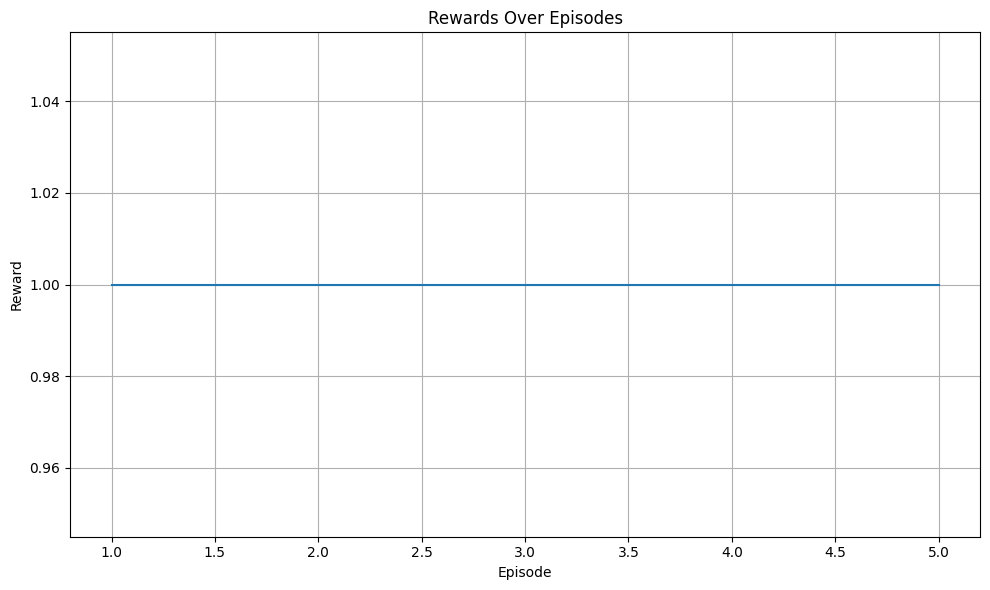

In [7]:
agent = PlanAgent()
is_done = False
rewards = []
for n_ep in range(NUM_EPISODES):
    print('Episode: ', n_ep)
    env.reset()
    total_reward = 0
    for i in range(T_MAX):
        action = agent.select_action()
        state, reward, is_done, truncated, _ = env.step(action)
        total_reward = total_reward + reward
        env.render()
        if is_done:
            break
    rewards.append(total_reward)
draw_rewards(rewards)

## Aprovechando el MDP: algoritmo de *value iteration*

Aquí tenéis una posible implementación del algoritmo de iteración de valor para la ecuación V*, usando arrays de NumPy. Observad cómo se actualizan los valores de V y cómo se utiliza el MDP que se puede consultar en el objeto del entorno:

In [8]:
class ValueIterationAgent:
    def __init__(self, env, gamma):
        self.env = env
        self.V = np.zeros(self.env.observation_space.n)
        self.gamma = gamma
        
    def calc_action_value(self, state, action):
        action_value = sum([prob * (reward + self.gamma * self.V[next_state])
                            for prob, next_state, reward, _ 
                            in self.env.unwrapped.P[state][action]]) 
        return action_value

    def select_action(self, state):
        best_action = best_value = None
        for action in range(self.env.action_space.n):
            action_value = self.calc_action_value(state, action)
            if not best_value or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action

    def value_iteration(self):
        max_diff = 0
        for state in range(self.env.observation_space.n):
            state_values = []
            for action in range(self.env.action_space.n):  
                state_values.append(self.calc_action_value(state, action))
            new_V = max(state_values)
            diff = abs(new_V - self.V[state])
            if diff > max_diff:
                max_diff = diff
            self.V[state] = new_V
        return self.V, max_diff
    
    def policy(self):   
        policy = np.zeros(env.observation_space.n) 
        for s in range(env.observation_space.n):
            Q_values = [self.calc_action_value(s,a) for a in range(self.env.action_space.n)] 
            policy[s] = np.argmax(np.array(Q_values))        
        return policy

Definimos una función para decidir cuándo parar la iteración de valor. También definimos una función para automatizar el entrenamiento. El algoritmo de iteración de valor se considera un algoritmo de aprendizaje por refuerzo activo y basado en modelo (que depende de un MDP).

En clase de teoría hemos visto la convergencia basada en la máxima diferencia entre valores de estados. Otra opción es la de definir un umbral de recompensa a partir del cual parar:

In [19]:
def check_improvements():
    reward_test = 0.0
    for i in range(NUM_EPISODES):
        total_reward = 0.0
        state, _ = env.reset()
        for i in range(T_MAX):
            action = agent.select_action(state)
            new_state, new_reward, is_done, truncated, _ = env.step(action)
            total_reward += new_reward
            if is_done: 
                break
            state = new_state
        reward_test += total_reward
    reward_avg = reward_test / NUM_EPISODES
    return reward_avg

def train(agent): 
    rewards = []
    max_diffs = []
    t = 0
    best_reward = 0.0
     
    while best_reward < REWARD_THRESHOLD:
        _, max_diff = agent.value_iteration()
        max_diffs.append(max_diff)
        print("After value iteration, max_diff = " + str(max_diff))
        t += 1
        last_reward = reward_test
        reward_test = check_improvements()
        print("Reward_test:" + str(reward_test))
        rewards.append(reward_test)
               
        if reward_test > best_reward:
            print(f"Best reward updated {reward_test:.2f} at iteration {t}") 
            best_reward = reward_test
    
    return rewards, max_diffs

Ahora ya podemos lanzar un entrenamiento:

In [20]:
agent = ValueIterationAgent(env, gamma=GAMMA)
rewards, max_diffs = train(agent)

After value iteration, max_diff = 1.0
Reward_test:0.0
After value iteration, max_diff = 0.95
Reward_test:0.0
After value iteration, max_diff = 0.9025
Reward_test:0.0
After value iteration, max_diff = 0.8573749999999999
Reward_test:0.0
After value iteration, max_diff = 0.8145062499999999
Reward_test:1.0
Best reward updated 1.00 at iteration 5


**¿Qué es lo que ocurre durante los primeros episodios? ¿Cómo lo interpretáis, por lo que conocéis del algoritmo?**

**Probad a modificar el código para que la parada sea por la diferencia entre valores de estado, poniendo un umbral que os parezca aceptable. ¿Qué método de parada os parece mejor en este escenario?**

La clase del agente incluye un método para calcular la política:

In [21]:
def print_policy(policy):
    visual_help = {0:'<', 1:'v', 2:'>', 3:'^'}
    policy_arrows = [visual_help[x] for x in policy]
    print(np.array(policy_arrows).reshape([-1, 4]))
    
policy = agent.policy()
print_policy(policy)

[['v' '>' 'v' '<']
 ['v' '<' 'v' '<']
 ['>' 'v' 'v' '<']
 ['<' '>' '>' '<']]


Una vez que el agente está entrenado, lo podemos poner en el entorno para probar su rendimiento:

Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4


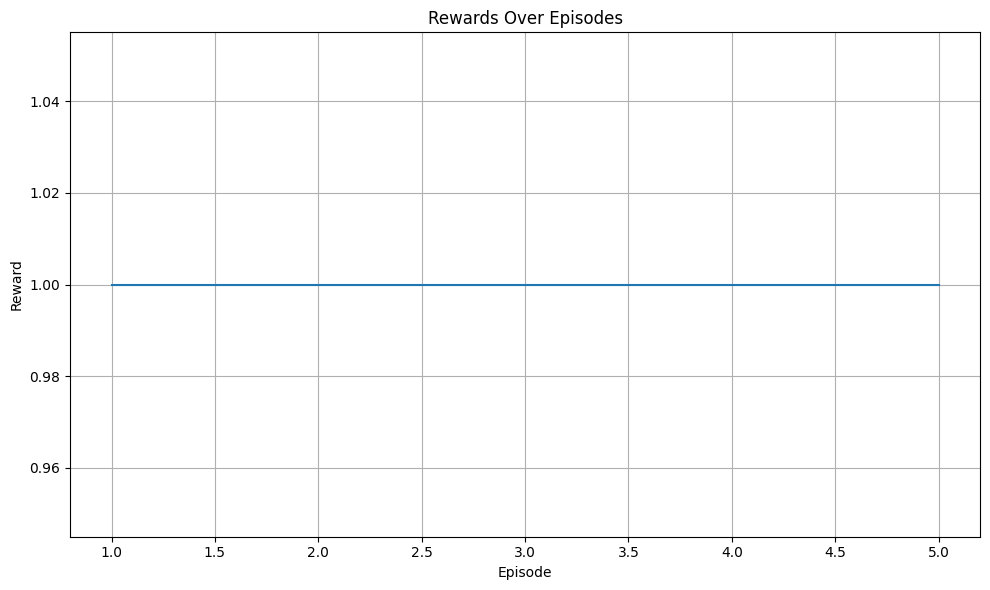

In [22]:
is_done = False
rewards = []
for n_ep in range(NUM_EPISODES):
    state, _ = env.reset()
    print('Episode: ', n_ep)
    total_reward = 0
    for i in range(T_MAX):
        action = agent.select_action(state)
        state, reward, is_done, truncated, _ = env.step(action)
        total_reward = total_reward + reward
        env.render()
        if is_done:
            break
    rewards.append(total_reward)
draw_rewards(rewards)